# Lunar Landing
Reference: https://gymnasium.farama.org/environments/box2d/lunar_lander/

## Description
This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

#### Action Space
There are four discrete actions available:
- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

#### Observaion Space
The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear velocities in `x` & `y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

#### Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

#### Starting State
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

#### Episode Termination
The episode finishes if:
1. the lander crashes (the lander body gets in contact with the moon);
2. the lander gets outside of the viewport (x coordinate is greater than 1);
3. the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

In [1]:
import cv2
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

## 1. Q-Learning

In this section, we train and evaluate a tabular Q-learning agent on the LunarLander-v3 environment using state discretization.


In [2]:
import gymnasium as gym
import numpy as np
import pickle
from utils.utils import Q_learning, discretize_env, discretize
from utils.utils import *

env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False)

### Step 1 - Train the Q learning agent

In [3]:
"""
# Train the agent using Q-learning
params = {
    'num_iteractions': 100_000,
    'alpha': 0.1,
    'gamma': 0.9,
    'epsilon':1.0,
    'decay': 0.0008,
    'bins_per_feature': 8
}

# Training a tabular Q-learning agent using discretization
Q_table, df_return_over_time = Q_learning(env, **params)


# Save the model
# Include timestamp in the filename
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"Q_learning_Q_table_{timestamp}.pkl"
with open(filename, "wb") as f:
    pickle.dump(Q_table, f)

# Save the training log history
log_filename = f"q_learning_training_log_{timestamp}.csv"
df_return_over_time.to_csv(log_filename, index=False)

"""


'\n# Train the agent using Q-learning\nparams = {\n    \'num_iteractions\': 100_000,\n    \'alpha\': 0.1,\n    \'gamma\': 0.9,\n    \'epsilon\':1.0,\n    \'decay\': 0.0008,\n    \'bins_per_feature\': 8\n}\n\n# Training a tabular Q-learning agent using discretization\nQ_table, df_return_over_time = Q_learning(env, **params)\n\n\n# Save the model\n# Include timestamp in the filename\nimport datetime\ntimestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")\nfilename = f"Q_learning_Q_table_{timestamp}.pkl"\nwith open(filename, "wb") as f:\n    pickle.dump(Q_table, f)\n\n# Save the training log history\nlog_filename = f"q_learning_training_log_{timestamp}.csv"\ndf_return_over_time.to_csv(log_filename, index=False)\n\n'

### Step 2 - Loading the trained Q learning agent

In [5]:
# Load the model
filename = "models/Q_learning_Q_table.pkl"

with open(filename, "rb") as f:
    Q_table = pickle.load(f)

### Step 3 - Visualizing performance during training 

In [6]:
# Visualize the training results
from IPython.display import Image, display
image_path = 'Q-Learning_reward_distribution.png'

try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
    print("Please check the filename and path.")


Error: The file 'Q-Learning_reward_distribution.png' was not found.
Please check the filename and path.


### Step 4 - Evaluation of the Q learning agent over 30 episodes 

In [6]:
# --- Environment & Bins Setup ---
env = gym.make("LunarLander-v3", render_mode="human", continuous=False)
DISCRETE_BUCKETS = 8  # must match what was used during training
bins = discretize_env(env, DISCRETE_BUCKETS=DISCRETE_BUCKETS)

# --- Evaluation ---
num_episodes = 30
all_rewards = []
successful_episodes = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    state_discrete = discretize(state, bins)
    done = False
    total_reward = 0

    while not done:
        # Greedy action from trained Q-table
        action_values = [Q_table.get((state_discrete, a), 0) for a in range(env.action_space.n)]
        action = np.argmax(action_values)

        next_state, reward, done, truncated, info = env.step(action)
        state_discrete = discretize(next_state, bins)
        total_reward += reward

        env.render()

    all_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    if total_reward >= 200:
        successful_episodes += 1

env.close()

# --- Summary Stats ---
mean_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)
success_rate = successful_episodes / num_episodes

print(f"\nEvaluation Summary over {num_episodes} episodes:")
print(f"Mean Reward: {mean_reward:.2f} Standard Deviation Reward:{std_reward:.2f}")
print(f"Success Rate (≥ 200 pts): {success_rate*100:.1f}%")
print("All Rewards:", all_rewards)

2025-06-26 09:50:49.249 Python[21288:25701825] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Episode 1: Total Reward = -122.44
Episode 2: Total Reward = -151.46
Episode 3: Total Reward = -101.80
Episode 4: Total Reward = -97.52
Episode 5: Total Reward = -122.28
Episode 6: Total Reward = -137.89
Episode 7: Total Reward = -136.64
Episode 8: Total Reward = -176.78
Episode 9: Total Reward = -119.11
Episode 10: Total Reward = -136.08
Episode 11: Total Reward = -113.47
Episode 12: Total Reward = -156.86
Episode 13: Total Reward = -166.17
Episode 14: Total Reward = -119.61
Episode 15: Total Reward = -141.31
Episode 16: Total Reward = -139.08
Episode 17: Total Reward = -136.11
Episode 18: Total Reward = -126.08
Episode 19: Total Reward = -152.71
Episode 20: Total Reward = -124.10
Episode 21: Total Reward = -161.49
Episode 22: Total Reward = -146.26
Episode 23: Total Reward = -148.83
Episode 24: Total Reward = -118.33
Episode 25: Total Reward = -132.54
Episode 26: Total Reward = -100.71
Episode 27: Total Reward = -125.79
Episode 28: Total Reward = -120.81
Episode 29: Total Reward = -12

In [ ]:
import matplotlib.pyplot as plt

# Visualize reward distribution for Q-learning
plt.figure(figsize=(8, 5))
plt.hist(all_rewards, bins=10, edgecolor='black')
plt.title("Q-Learning: Reward Distribution over 30 Evaluation Episodes")
plt.xlabel("Episode Return")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("Q_learning_eval_reward_distribution.png")
plt.show()

### 1.1 Q-Learning Hyperparameter Tuning (Commented for Runtime Efficiency)


The following cells contain the complete hyperparameter tuning pipeline for Q-learning using Optuna. These cells were **commented out** to avoid re-running long training sessions during notebook execution.

The final training configuration used in the Q-learning section above was selected **based on the best parameters found during this tuning process**.

For reference, the tuning process:
- Searched over `alpha`, `gamma`, `epsilon_decay`, and `bins_per_feature`
- Used 30 Optuna trials, each training a Q-learning agent over 5000 episodes
- Selected the best configuration based on smoothed return performance

The best hyperparameters found were then used to retrain the Q-learning agent for 100,000 episodes, whose performance was evaluated in the final section.

*To re-run the tuning, uncomment the cells below.*



#### Step 1. Import Optuna & Setup

In [ ]:
"""
import optuna
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def make_env():
    return gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False)

"""


#### Step 2. Define Objective Function

In [ ]:
"""
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    gamma = trial.suggest_float("gamma", 0.8, 0.999)
    decay = trial.suggest_float("epsilon_decay", 1/3000, 1/500)
    bins = trial.suggest_int("bins_per_feature", 6, 18)

    env = make_env()
    Q_table, df_return_over_time = Q_learning(
        env,
        num_iteractions=5000,
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0,
        decay=decay,
        bins_per_feature=bins
    )
    env.close()

    df_return_over_time["Smoothed"] = df_return_over_time["Return"].rolling(100).mean()
    final_return = df_return_over_time["Smoothed"].iloc[-1]
    return final_return



"""


#### Step 3. Run the Tuning

In [ ]:
"""

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best final return:", study.best_value)


"""


[I 2025-06-22 11:33:17,587] A new study created in memory with name: no-name-a4e62a93-e2a3-46ca-8e7e-5a55d02d6eb5
100%|██████████| 1500/1500 [00:14<00:00, 104.98it/s]
[I 2025-06-22 11:33:31,907] Trial 0 finished with value: -310.46632866229663 and parameters: {'alpha': 0.7791789758936839, 'gamma': 0.8822015921650008, 'epsilon_decay': 0.001539304363051415, 'bins_per_feature': 7}. Best is trial 0 with value: -310.46632866229663.
100%|██████████| 1500/1500 [00:13<00:00, 112.55it/s]
[I 2025-06-22 11:33:45,240] Trial 1 finished with value: -238.64644642928513 and parameters: {'alpha': 0.8081081873847407, 'gamma': 0.8397481026722239, 'epsilon_decay': 0.0013490556152786686, 'bins_per_feature': 7}. Best is trial 1 with value: -238.64644642928513.
100%|██████████| 1500/1500 [01:13<00:00, 20.38it/s]
[I 2025-06-22 11:34:58,865] Trial 2 finished with value: -74.86983619916697 and parameters: {'alpha': 0.5517793888049257, 'gamma': 0.8563705416037143, 'epsilon_decay': 0.0017360203788933698, 'bins_pe

Best hyperparameters: {'alpha': 0.2312127841031655, 'gamma': 0.9922964750407784, 'epsilon_decay': 0.0010888436963175303, 'bins_per_feature': 6}
Best final return: -45.593717868968064


#### Step 4. Visualize & Save Results of Best Config

In [ ]:
"""


# Visualize training with best configuration
best = study.best_params
env = make_env()

Q_table, df_return_over_time = Q_learning(
    env,
    num_iteractions=100_000,    
    alpha=best["alpha"],
    gamma=best["gamma"],
    epsilon=1.0,
    decay=best["epsilon_decay"],
    bins_per_feature=best["bins_per_feature"]
)
env.close()

visualize_results(
    df_return_over_time,
    Q_table,
    bins_per_feature=best["bins_per_feature"],
    algorithm="Q_learning_tuned"
)

# Save the tuned Q-learning model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"Q_learning_Q_table_tuned_{timestamp}.pkl"
with open(filename, "wb") as f:
    pickle.dump(Q_table, f)

# Save results to CSV
df_return_over_time.to_csv("final_results_Q_learning_tuned.csv", index=False)


"""


---

## 2. SARSA: On-Policy Temporal Difference Learning

In this section, we apply SARSA (State-Action-Reward-State-Action), an on-policy model-free reinforcement learning algorithm, to solve the LunarLander-v3 environment using tabular Q-learning with discretization.


In [1]:
import gymnasium as gym
import numpy as np
import pickle
from LL_utils import SARSA_control

env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False)


### Step 1 - Train the SARSA agent

In [ ]:
"""

params = {
    'num_iteractions': 100_000,
    'alpha': 0.2,
    'gamma': 0.8,
    'epsilon': 1.0,
    'decay': 0.0011,
    'bins_per_feature': 8
}

Q_table, df_return_over_time = SARSA_control(env, **params)


# Save SARSA model with timestamp
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"SARSA_Q_table_{timestamp}.pkl"
with open(filename, "wb") as f:
    pickle.dump(Q_table, f)


# Save the training log history
log_filename = f"sarsa_training_log_{timestamp}.csv"
df_return_over_time.to_csv(log_filename, index=False)

"""



### Step 2 - Loading the trained SARSA agent

In [2]:
# Load the model
filename = "SARSA_Q_table.pkl"


with open(filename, "rb") as f:
    Q_table = pickle.load(f)

### Step 3 - Visualizing performance during training 

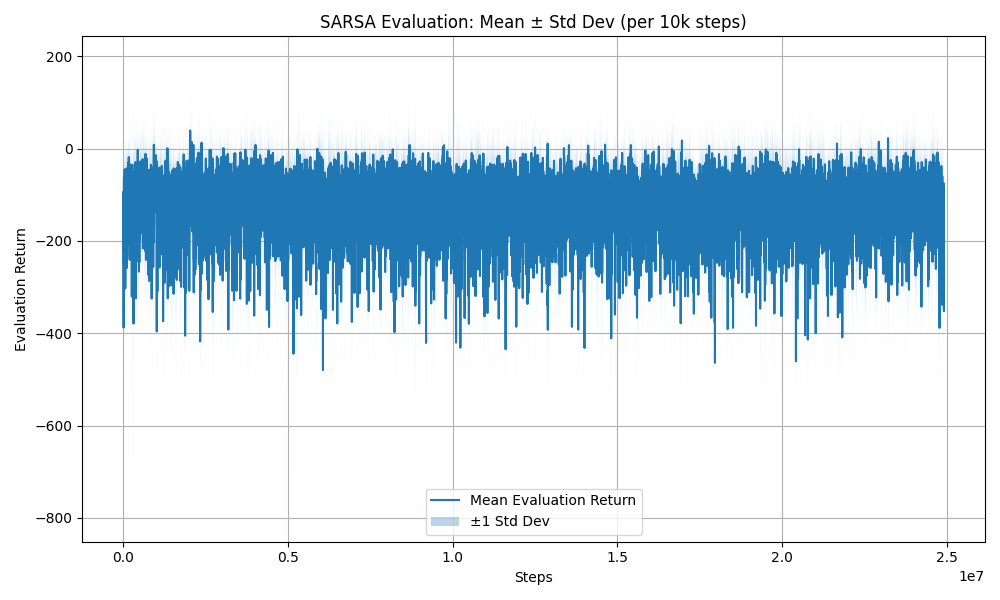

In [4]:
from IPython.display import Image, display

# Visualize the training results
image_path = 'SARSA_reward_distribution.png'

try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
    print("Please check the filename and path.")


### Step 4 - Evaluation of the SARSA agent over 30 episodes

In [5]:
import gymnasium as gym
import numpy as np
from LL_utils import discretize_env, discretize, Q_table_epsilon_greedy_policy

# --- Environment & Bins Setup ---
env = gym.make("LunarLander-v3", render_mode="human", continuous=False)
DISCRETE_BUCKETS = 8 
bins = discretize_env(env, DISCRETE_BUCKETS=DISCRETE_BUCKETS)

# --- Evaluation ---
num_episodes = 30
all_rewards = []
successful_episodes = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    state_discrete = discretize(state, bins)
    done = False
    total_reward = 0

    # Initial greedy action
    action = Q_table_epsilon_greedy_policy(env, state_discrete, Q_table, epsilon=0.0)

    while not done:
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        next_state_discrete = discretize(next_state, bins)
        action = Q_table_epsilon_greedy_policy(env, next_state_discrete, Q_table, epsilon=0.0)
        state_discrete = next_state_discrete

        env.render()

    all_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    if total_reward >= 200:
        successful_episodes += 1

env.close()

# --- Summary Stats ---
mean_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)
success_rate = successful_episodes / num_episodes

print(f"\nEvaluation Summary over {num_episodes} episodes:")
print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Success Rate (≥ 200 pts): {success_rate*100:.1f}% ({successful_episodes}/{num_episodes})")
print("All Rewards:", all_rewards)


2025-06-26 12:29:00.445 Python[57686:26193411] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Episode 1: Total Reward = -191.32
Episode 2: Total Reward = -64.36
Episode 3: Total Reward = -230.00
Episode 4: Total Reward = -1036.91
Episode 5: Total Reward = -290.91
Episode 6: Total Reward = -16.37
Episode 7: Total Reward = -78.93
Episode 8: Total Reward = -431.69
Episode 9: Total Reward = -84.72
Episode 10: Total Reward = -372.10
Episode 11: Total Reward = -367.13
Episode 12: Total Reward = -6.11
Episode 13: Total Reward = -145.61
Episode 14: Total Reward = -67.12
Episode 15: Total Reward = -93.31
Episode 16: Total Reward = -323.40
Episode 17: Total Reward = -74.45
Episode 18: Total Reward = -311.36
Episode 19: Total Reward = -91.74
Episode 20: Total Reward = -213.27
Episode 21: Total Reward = -89.15
Episode 22: Total Reward = -365.11
Episode 23: Total Reward = -844.35
Episode 24: Total Reward = -387.59
Episode 25: Total Reward = -129.72
Episode 26: Total Reward = -176.38
Episode 27: Total Reward = -154.19
Episode 28: Total Reward = -434.27
Episode 29: Total Reward = -72.34
Episo

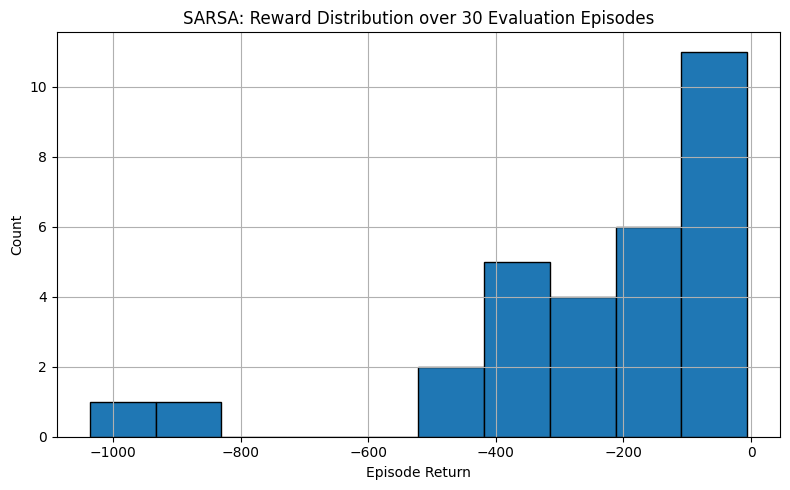

In [6]:
import matplotlib.pyplot as plt

# Visualize reward distribution for SARSA
plt.figure(figsize=(8, 5))
plt.hist(all_rewards, bins=10, edgecolor='black')
plt.title("SARSA: Reward Distribution over 30 Evaluation Episodes")
plt.xlabel("Episode Return")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("SARSA_eval_reward_distribution.png")
plt.show()


### 2.1 SARSA Hyperparameter Tuning (Commented for Runtime Efficiency)

The following cells contain the complete hyperparameter tuning pipeline for SARSA using Optuna. These cells were **commented out** to avoid re-running long training sessions during notebook execution.

The final training configuration used in the SARSA section above was selected **based on the best parameters found during this tuning process**.

For reference, the tuning process:
- Searched over `alpha`, `gamma`, `epsilon_decay`, and `bins_per_feature`
- Used 30 Optuna trials, each training a SARSA agent over 5000 episodes
- Selected the best configuration based on smoothed return performance

The best hyperparameters found were then used to retrain the SARSA agent for 100,000 episodes, whose performance was evaluated in the final section.

*To re-run the tuning, uncomment the cells below.*

In [ ]:
"""
import optuna
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def make_env():
    return gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False)

"""


In [ ]:
"""

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    gamma = trial.suggest_float("gamma", 0.8, 0.999)
    decay = trial.suggest_float("epsilon_decay", 1/3000, 1/500)
    bins = trial.suggest_int("bins_per_feature", 6, 18)

    env = make_env()
    Q_table, df_return_over_time = SARSA_control(
        env,
        num_iteractions=5000,
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0,
        decay=decay,
        bins_per_feature=bins
    )
    env.close()

    df_return_over_time["Smoothed"] = df_return_over_time["Return"].rolling(100).mean()
    final_return = df_return_over_time["Smoothed"].iloc[-1]
    return final_return


"""


In [ ]:
"""
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best final return:", study.best_value)
"""


In [ ]:
"""
best = study.best_params
env = make_env()

#Trains a new SARSA agent from scratch using the best hyperparameters, for 2000 episodes.
Q_table, df_return_over_time = SARSA_control(
    env,
    num_iteractions=100_00,
    alpha=best["alpha"],
    gamma=best["gamma"],
    epsilon=1.0,
    decay=best["epsilon_decay"],
    bins_per_feature=best["bins_per_feature"]
)
env.close()

visualize_results(
    df_return_over_time,
    Q_table,
    bins_per_feature=best["bins_per_feature"],
    algorithm="SARSA_tuned"
)

# Save the tuned SARSA model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"SARSA_Q_table_tuned_{timestamp}.pkl"
with open(filename, "wb") as f:
    pickle.dump(Q_table, f)

# Save results to CSV
df_return_over_time.to_csv("final_results_SARSA_tuned.csv", index=False)

"""


---

## 3. Proximal Policy Optimization (PPO)

In this section, we use the PPO algorithm from Stable-Baselines3, a deep reinforcement learning method that works directly with continuous state spaces.


### Step 1 - Train the PPO agent

In [ ]:
# PPO Training Setup — Commented out to avoid re-running long training

# from stable_baselines3 import PPO
# import gymnasium as gym
# from stable_baselines3.common.monitor import Monitor
# from PPO_callbacks import CustomEvalCallback
# from LL_utils import CustomEvalCallback

# env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False)

# model = PPO(
#     policy="MlpPolicy",
#     env=env,
#     learning_rate=0.0009961905933562238,
#     n_steps=1856,
#     batch_size=128,
#     n_epochs=10,
#     gamma=0.9925093010215817,
#     gae_lambda=0.9998441353008047,
#     clip_range=0.3293625233828218,
#     ent_coef=0.01012707017115083,
#     vf_coef=0.18524091314533547,
#     max_grad_norm=0.7173590140832038,
#     verbose=0,
# )

# train_env = Monitor(gym.make("LunarLander-v3"))
# eval_env = Monitor(gym.make("LunarLander-v3"))

# eval_callback = CustomEvalCallback(
#     eval_env=eval_env,
#     eval_freq=10_000,
#     n_eval_episodes=10,
#     deterministic=True,
#     render=False,
#     best_model_save_path="./logs/best_model/",
#     log_path="./logs/results/",
#     verbose=1,
# )

# model.learn(total_timesteps=500_000, callback=eval_callback)
# model.save("ppo_lunarlander_model")


### Step 2 - Loading the trained PPO agent

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.save_util import load_from_zip_file
import gymnasium as gym

# Manually load the data (bypass validation)
data, params, _ = load_from_zip_file("PPO/ppo_lunarlander_model")

# Rebuild the PPO model manually
env = gym.make("LunarLander-v3", render_mode="human")

model = PPO(
    policy="MlpPolicy",
    env=env,
    **data["policy_kwargs"]
)

# Load weights
model.set_parameters(params)


### Step 3 - Visualizing performance during training 

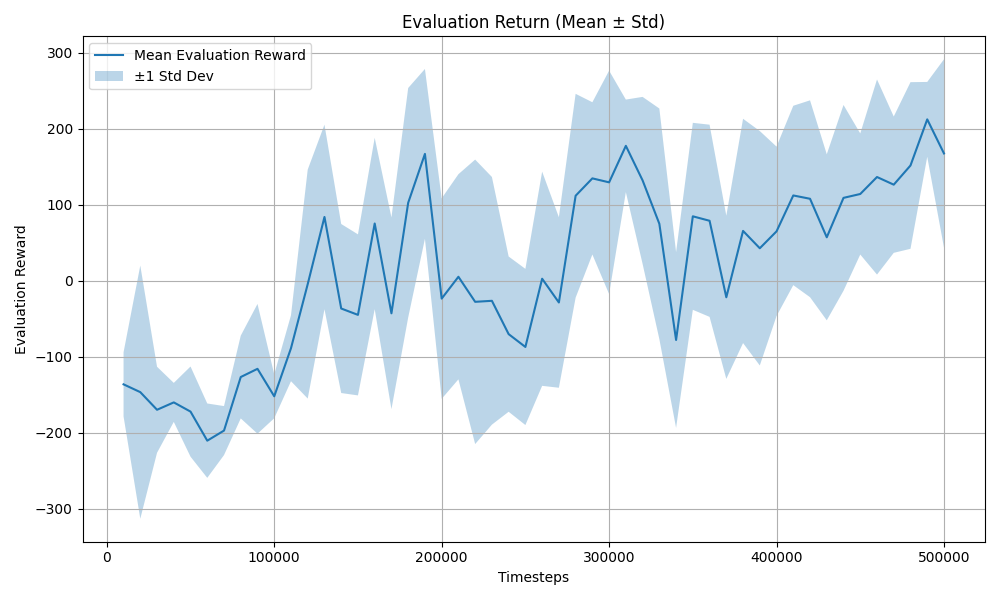

In [12]:
from IPython.display import Image, display

# Paths to saved plots
image_path = "PPO/PPO_reward_distribution mean and std.png"
    

try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
    print("Please check the filename and path.")


### Step 4 - Evaluation of the PPO agent over 30 episodes 

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

# Run evaluation
rewards, _ = evaluate_policy(model, env, n_eval_episodes=30, return_episode_rewards=True)

# Analyze performance
mean_reward = np.mean(rewards)
std_reward = np.std(rewards)
successes = sum(r >= 200 for r in rewards)
success_rate = successes / len(rewards)

# Report
print(f"\nPPO Evaluation Summary over 30 episodes:")
print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Success Rate (≥ 200 pts): {success_rate*100:.1f}% ({successes}/{len(rewards)})")
print("All Rewards:", rewards)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



PPO Evaluation Summary over 30 episodes:
Mean Reward: 172.96 ± 102.27
Success Rate (≥ 200 pts): 66.7% (20/30)
All Rewards: [219.37803817534666, 34.60191236808896, 240.21054389090713, -20.02931933104992, 2.85512163862586, 230.6472905948759, 240.80361575740113, -5.57263087364845, 230.8442414942072, 268.9421607334209, 9.332907045260072, 272.0472735006957, 118.90584242492332, 4.225330310873687, 210.1461972465209, 232.47697539478003, 37.5413386374712, 225.7388117958326, 223.71062144659584, 267.23359366951195, 235.63976990416586, 253.29358590409436, 235.15834505015175, 123.43389787182241, 271.18027139319065, 45.28752661217004, 233.04916385647203, 238.39235991277005, 254.852900791271, 254.43055620685132]


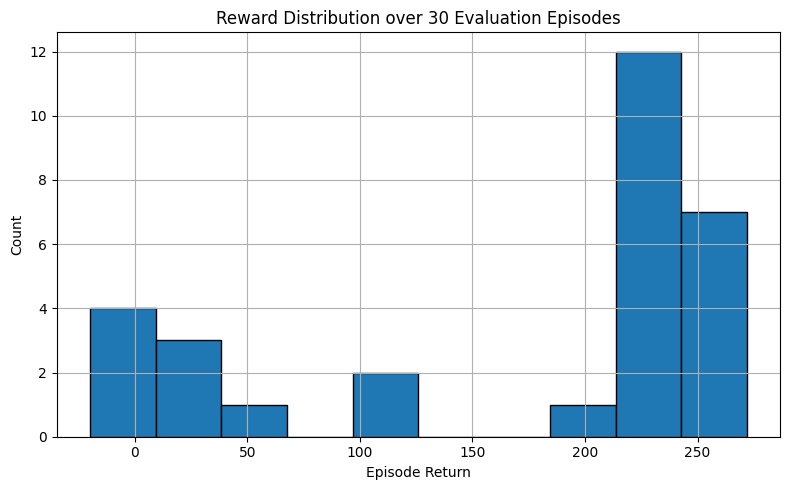

In [ ]:
# Visualize the distribution of rewards using a histogram
import matplotlib.pyplot as plt

# Create histogram of episode returns
plt.figure(figsize=(8, 5))
plt.hist(rewards, bins=10, edgecolor='black')
plt.title("Reward Distribution over 30 Evaluation Episodes")
plt.xlabel("Episode Return")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("PPO_eval_reward_distribution.png")
plt.show()


### 3.3 PPO Hyperparameter Tuning (Commented for Runtime Efficiency)

The following cells implement the **complete hyperparameter tuning pipeline** for PPO using **Optuna**.

These cells were **commented out** to avoid running long training sessions when opening the notebook. The final PPO configuration used earlier was based on the **best-performing hyperparameters found here**.

**Tuning setup:**
- Search space includes key PPO hyperparameters such as:
  - `learning_rate`, `gamma`, `gae_lambda`, `clip_range`, `ent_coef`, `vf_coef`
  - Training-related: `n_steps`, `batch_size`, `n_epochs`, `max_grad_norm`
  - Policy architecture: `log_std_init`, `ortho_init`
- 30 Optuna trials, each training a PPO agent for 150,000 timesteps
- A custom pruning callback stops bad trials early
- Best model is retrained for 300,000 timesteps and saved

*To re-run the tuning, uncomment the cells below.*


#### Step 1: Imports and Callback Definition

In [ ]:
# from tqdm import tqdm
# import optuna
# import torch
# import pandas as pd
# import gymnasium as gym
# from stable_baselines3 import PPO
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import BaseCallback

# class TrialPruningCallback(BaseCallback):
#     def __init__(self, trial, eval_env, n_eval_episodes=5, check_freq=10_000, verbose=0):
#         super().__init__(verbose)
#         self.trial = trial
#         self.eval_env = eval_env
#         self.check_freq = check_freq
#         self.n_eval_episodes = n_eval_episodes

#     def _on_step(self) -> bool:
#         if self.n_calls % self.check_freq == 0:
#             mean_reward, _ = evaluate_policy(self.model, self.eval_env, n_eval_episodes=self.n_eval_episodes, warn=False)
#             self.trial.report(mean_reward, self.n_calls)
#             if self.trial.should_prune():
#                 raise optuna.exceptions.TrialPruned()
#         return True


#### Step 2: Objective Function

In [ ]:
# def make_env():
#     return Monitor(gym.make("LunarLander-v3"))

# def objective(trial):
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
#     gamma = trial.suggest_float("gamma", 0.95, 0.9999)
#     gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
#     clip_range = trial.suggest_float("clip_range", 0.1, 0.4)
#     ent_coef = trial.suggest_float("ent_coef", 0.0, 0.02)
#     vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0)
#     max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 1.0)
#     n_epochs = trial.suggest_int("n_epochs", 3, 10)
#     n_steps = trial.suggest_int("n_steps", 128, 2048, step=64)
#     batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])

#     policy_kwargs = dict(
#         log_std_init=trial.suggest_float("log_std_init", -1.0, 1.0),
#         ortho_init=trial.suggest_categorical("ortho_init", [True, False]),
#         net_arch=[dict(pi=[64, 64], vf=[64, 64])],
#         activation_fn=torch.nn.Tanh
#     )

#     env = make_vec_env(make_env, n_envs=1)
#     eval_env = make_env()

#     model = PPO(
#         policy="MlpPolicy",
#         env=env,
#         learning_rate=learning_rate,
#         n_steps=n_steps,
#         batch_size=batch_size,
#         n_epochs=n_epochs,
#         gamma=gamma,
#         gae_lambda=gae_lambda,
#         clip_range=clip_range,
#         ent_coef=ent_coef,
#         vf_coef=vf_coef,
#         max_grad_norm=max_grad_norm,
#         policy_kwargs=policy_kwargs,
#         verbose=0,
#     )

#     callback = TrialPruningCallback(trial, eval_env, n_eval_episodes=5, check_freq=10_000)
#     try:
#         model.learn(total_timesteps=150_000, callback=callback)
#         mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10, warn=False)
#     except optuna.exceptions.TrialPruned:
#         raise
#     finally:
#         env.close()
#         eval_env.close()

#     return mean_reward


#### Step 3: Study Execution and Saving

In [ ]:
# study = optuna.create_study(
#     direction="maximize",
#     sampler=optuna.samplers.TPESampler(),
#     pruner=optuna.pruners.MedianPruner()
# )

# study.optimize(objective, n_trials=30)

# print("\nBest Trial:")
# print(f"  Reward: {study.best_value}")
# print(f"  Params: {study.best_params}")

# df_trials = study.trials_dataframe()
# df_trials.to_csv("ppo_optuna_results.csv", index=False)
# print("Saved results to 'ppo_optuna_results.csv'")
